# Question 1
 How are income, race, and pollution relevant to EV charger number in the State of California? Can we use demographic characteristics to predict where future EV chargers will be built?


For this question, we used data from the 
- 2020 American Community Survey (5-Year Estimate) 
- CalEnviroScreen 4.0
- National Renewable Energy Laboratory electric vehicle public charger locations

We acquired ACS data using the census.gov API since the dataset was not available via the cenpy package. We pulled median household income, median gross rent, and housing unit data. Then we joined the data from ACS to the CalEnviroScreen shapefile. We also requested charger locations from NREL and filtered the dataset to only return public chargers. We then did a spatial join to identify how many chargers each tract has. To learn more about how the data was requested and joined, please refer to [this notebook](https://).

In [1]:
import pandas as pd
import geopandas as gpd

We first read the GeoJson file into a geodataframe which consists of census data and CalEnviroScreen data.

In [ ]:
joinedDf = gpd.read_file('data/joinedDf.geojson')

I was wondering why this specific census tract has so many chargers (304 to be exact so i had to look it up and apparently it's Menlo Park so I guess it does make a lot of sense)

In [109]:
chargers_by_tract.sort_values('count', ascending = False).head()

,count
Tract,
6081611700,304
6085505202,194
6081602300,186
6059052518,132
6059062614,107


Out of 8035 census tracts in California, only 2837 tracts have public EV chargers. 

In [110]:
print('tractsDf length: {}'.format(len(tractsDf)))
print('chargers length: {}'.format(len(chargers)))
print('chargers_sjoin length: {}'.format(len(chargers_sjoin)))

tractsDf length: 8035
chargers length: 14017
chargers_sjoin length: 13981


In [53]:
# now let's plot them just to make sure they are in CA
import contextily as ctx
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10,10))
# chargers.to_crs("EPSG:3857").plot(ax=ax)
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

[]

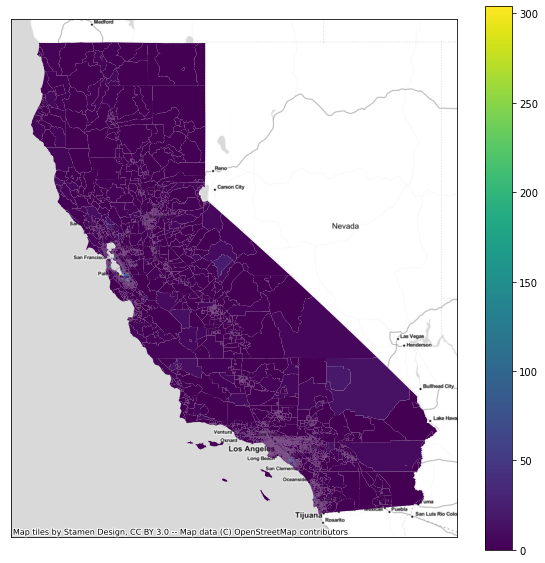

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
joinedDf.to_crs("EPSG:3857").plot('count', cmap='viridis', legend=True, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
#there seems to be a couple that aren't in CA so let's remove those
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html#geopandas.GeoDataFrame.cx
#CA bounding box coordinates:
#31, -112
#42, -126
chargers = chargers.cx[-126:-112, 31:42]

#plot again just to check
fig, ax = plt.subplots(figsize=(10,10))
chargers.to_crs("EPSG:3857").plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas)

## Running a Linear Regression Model

In [111]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [106]:
joinedDf_dropna = joinedDf.dropna()

In [109]:
x = joinedDf_dropna['B19013_001E'].to_numpy().reshape(-1,1)
y = joinedDf_dropna['count'].to_numpy()

In [112]:
model = LinearRegression()

In [114]:
model = LinearRegression().fit(x, y)

In [116]:
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.001207310018450758


The R-squared value is extremely low. This probably tells us that income is extremely non-indicative of EV charger count. 

## Running a Random Forest Model

First we create a binary variable to indicate whether a census tract has 

In [113]:
joinedDf['hasChargers'] = joinedDf['count'].apply(lambda x: True if x > 0 else False)

In [114]:
joinedDf.head()

,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,PM2_5_P,...,DP04_0008E,DP04_0009E,DP04_0010E,DP04_0011E,DP04_0012E,DP04_0013E,Income,Rent,count,hasChargers
Tract,,,,,,,,,,,,,,,,,,,,,
6083002103,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,10.031114,...,70,23,115,255,137,331,55000,1289,10.0,True
6083002402,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,10.454263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,True
6083002102,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,9.931549,...,28,15,19,15,9,66,74083,1525,4.0,True
6083002010,93455,Santa Barbara,Orcutt,4496,6.639331,5.988401,0.036244,13.615432,7.660570,10.653391,...,0,0,0,0,0,0,115750,2279,0.0,False
6083002009,93455,Santa Barbara,Orcutt,4008,14.022852,23.121533,0.036244,13.615432,7.663210,10.690728,...,42,0,7,98,0,7,91463,1679,0.0,False


In [133]:
from sklearn.model_selection import train_test_split

xvars = ['TotPop19', 'CIscore', 'CIscoreP',
       'Ozone', 'OzoneP', 'PM2_5', 'PM2_5_P', 'DieselPM', 'DieselPM_P',
       'Pesticide', 'PesticideP', 'Tox_Rel', 'Tox_Rel_P', 'Traffic',
       'TrafficP', 'DrinkWat', 'DrinkWatP', 'Lead', 'Lead_P', 'Cleanup',
       'CleanupP', 'GWThreat', 'GWThreatP', 'HazWaste', 'HazWasteP',
       'ImpWatBod', 'ImpWatBodP', 'SolWaste', 'SolWasteP', 'PollBurd',
       'PolBurdSc', 'PolBurdP', 'Asthma', 'AsthmaP', 'LowBirtWt', 'LowBirWP',
       'Cardiovas', 'CardiovasP', 'Educatn', 'EducatP', 'Ling_Isol',
       'Ling_IsolP', 'Poverty', 'PovertyP', 'Unempl', 'UnemplP', 'HousBurd',
       'HousBurdP', 'PopChar', 'PopCharSc', 'PopCharP', 'Child_10',
       'Pop_10_64', 'Elderly65', 'Hispanic', 'White', 'AfricanAm', 'NativeAm',
       'OtherMult',  'AAPI', 'DP04_0006E', 'DP04_0007E', 'DP04_0008E', 'DP04_0009E', 'DP04_0010E',
       'DP04_0011E', 'DP04_0012E', 'DP04_0013E', 'Income', 'Rent' ]
yvar = 'hasChargers'

In [134]:
# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

5143 5143
1715 1715


In [135]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

In [136]:
y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ...,  True, False,  True])

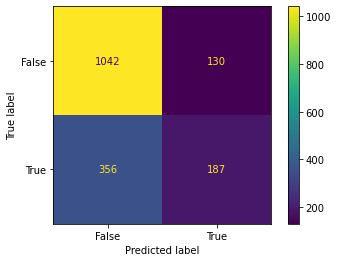

In [137]:
#confusion matrix of results without incorporating housing unit data

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

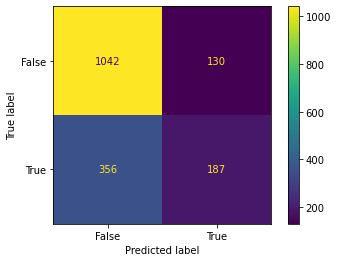

In [138]:
#confusion matrix after incorporating housing data

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#barely improved the accuracy result by 0.004

In [139]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7166


In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.89      0.81      1172
        True       0.59      0.34      0.43       543

    accuracy                           0.72      1715
   macro avg       0.67      0.62      0.62      1715
weighted avg       0.70      0.72      0.69      1715



## Neural network